# BERT for Sequence Classification (Re-implementation)

In [ ]:
# Global variables

BATCH_SIZE = 32
MODEL_NAME = 'nlpaueb/legal-bert-small-uncased'#'bert-base-uncased'
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 2

### Installation of packages

In [ ]:
!pip install transformers
!pip install torch-lr-finder

### Imports

In [ ]:
import torch
import os
from transformers import BertTokenizer
from google.colab import drive
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

### Device

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

### Reading dataset

In [ ]:
# Mount drive to have access to your files
drive.mount('/content/drive')

In [ ]:
# Funtion to read all sentences
def get_sentences(path):
    sentences= []
    for filename in sorted(os.listdir(path)):
        with open(path+filename, 'r') as f:
            for sentence in f :
                sentences.append(sentence)
    return sentences

In [ ]:
# Function to read get all labels
def get_labels(path):
    all_labels = []
    for filename in sorted(os.listdir(path)):
        file_labels = []
        with open(path+filename, 'r') as f:
            for label in f :
                all_labels.append(int(label))
    return all_labels

In [ ]:
# Reading sentences and labels
all_sentences = get_sentences("ToS/Sentences/")
all_labels = get_labels("ToS/Labels/")

In [ ]:
# Since unfair sentences are marked as "-1", we change them to "0" for simplicity
#all_labels =  [0 if label ==-1 else label for label in all_labels]

assert len(all_sentences) == len(all_labels)
print(len(all_sentences)) #9037

### Bert Tokenizer

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True) # the model 'bert-base-uncased' only contains lower case sentences

In [ ]:
# ==> Example of first sentence

# Print the original sentence.
print(' Original: ', all_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(all_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(all_sentences[0])))

In [ ]:
# ==> Get the max length of a sentence

max_len = 0

# For every sentence...
for sent in all_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

#### Tokenize dataset

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
tmp_bool = True

# For every sentence...
for sent in all_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Pad & truncate all sentences.
                        pad_to_max_length = True, #is deprecated
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    if tmp_bool:
      tmp_bool = False
      print(f'Keys of encoded_dict: {encoded_dict.keys()}')
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(all_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', all_sentences[0])
print('Token IDs:', input_ids[0])

#### Dataset split

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

"""
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
"""

train_idx, valid_idx = train_test_split(np.arange(len(labels)), test_size=0.05, shuffle=True, stratify=labels)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

"""
7,531 training samples
1,883 validation samples
=====
9,414

Second part with test_set
8048
424

Third part with test_set and 4% for test
8585
452
"""

'\n7,531 training samples\n1,883 validation samples\n=====\n9,414\n\nSecond part with test_set\n8048\n424\n\nThird part with test_set and 4% for test\n'

In [ ]:
#print(f'Len training {len(train_idx)} and validation {len(valid_idx)}')

Len training 8585 and validation 452


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = BATCH_SIZE

"""
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
"""

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

### Training classification model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = NUM_CLASSES, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

### Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,#2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  #weight_decay=0.01
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = EPOCHS

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
"""
from torch.optim.lr_scheduler import CosineAnnealingLR
MIN_LR = 1e-5
scheduler = CosineAnnealingLR(optimizer, 600, eta_min = MIN_LR)

### Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    """
    print(f'preds.shape {preds.shape} == {preds}')
    print(f'labels.shape {labels.shape} == {labels}')
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    """
    print(f'pred_flat.shape {pred_flat.shape} == {pred_flat}')
    print(f'labels_flat.shape {labels_flat.shape} == {labels_flat}')
    """
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
tr_metrics = []
va_metrics = []
tmp_print_flag = True


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    io_total_train_acc = 0
    io_total_train_prec = 0
    io_total_train_recall = 0
    io_total_train_f1 = 0
    io_total_valid_acc = 0
    io_total_valid_prec = 0
    io_total_valid_recall = 0
    io_total_valid_f1 = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        """
        if tmp_print_flag:
          tmp_print_flag = False
          print(f'result.keys() = {result.keys()}')
        """

        loss = result.loss
        logits = result.logits

        """
        print(f'loss {loss}')
        print(f'logits {logits}')
        """
        train_preds.extend(logits.argmax(dim=1).cpu().numpy())
        train_targets.extend(batch[2].numpy())

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        train_acc = accuracy_score(train_targets, train_preds)
        train_precision = precision_score(train_targets, train_preds)
        train_recall = recall_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        io_total_train_acc += train_acc
        io_total_train_prec += train_precision
        io_total_train_recall += train_recall
        io_total_train_f1 += train_f1

    io_avg_train_acc = io_total_train_acc / len(train_dataloader)
    io_avg_train_prec = io_total_train_prec / len(train_dataloader)
    io_avg_train_recall = io_total_train_recall / len(train_dataloader)
    io_avg_train_f1 = io_total_train_f1 / len(train_dataloader)
    print(
        f'Epoch {epoch_i+1} : \n\
        Train_acc : {io_avg_train_acc}\n\
        Train_F1 : {io_avg_train_f1}\n\
        Train_precision : {io_avg_train_prec}\n\
        Train_recall : {io_avg_train_recall}'
    )

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    valid_preds = []
    valid_targets = []

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits

        valid_preds.extend(logits.argmax(dim=1).cpu().numpy())
        valid_targets.extend(batch[2].numpy())

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        valid_acc = accuracy_score(valid_targets, valid_preds)
        valid_precision = precision_score(valid_targets, valid_preds)
        valid_recall = recall_score(valid_targets, valid_preds)
        valid_f1 = f1_score(valid_targets, valid_preds)

        io_total_valid_acc += valid_acc
        io_total_valid_prec += valid_precision
        io_total_valid_recall += valid_recall
        io_total_valid_f1 += valid_f1

    io_avg_valid_acc = io_total_valid_acc / len(validation_dataloader)
    io_avg_valid_prec = io_total_valid_prec / len(validation_dataloader)
    io_avg_valid_recall = io_total_valid_recall / len(validation_dataloader)
    io_avg_valid_f1 = io_total_valid_f1 / len(validation_dataloader)
    print(
            f'Epoch {epoch_i+1} : \n\
            Valid_acc : {io_avg_valid_acc}\n\
            Valid_F1 : {io_avg_valid_f1}\n\
            Valid_precision : {io_avg_valid_prec}\n\
            Valid_recall : {io_avg_valid_recall}'
          )

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': io_avg_train_acc,
            'Training F1': io_avg_train_f1,
            'Training Precision': io_avg_train_prec, 
            'Training Recall': io_avg_train_recall,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. F1': io_avg_valid_f1,
            'Valid. Precision': io_avg_valid_prec, 
            'Valid. Recall': io_avg_valid_recall,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Accur.,Training F1,Training Precision,Training Recall,Valid. Loss,Valid. Accur.,Valid. F1,Valid. Precision,Valid. Recall,Training Time,Validation Time
epoch,,,,,,,,,,,,
1,0.23,0.88,0.26,0.41,0.20,0.16,0.95,0.78,0.71,0.89,0:01:58,0:00:02
2,0.12,0.96,0.78,0.84,0.73,0.12,0.96,0.78,0.77,0.80,0:01:56,0:00:02
3,0.10,0.97,0.86,0.89,0.83,0.11,0.96,0.85,0.85,0.85,0:01:56,0:00:02


##### Loss per epoch - Training VS Validation


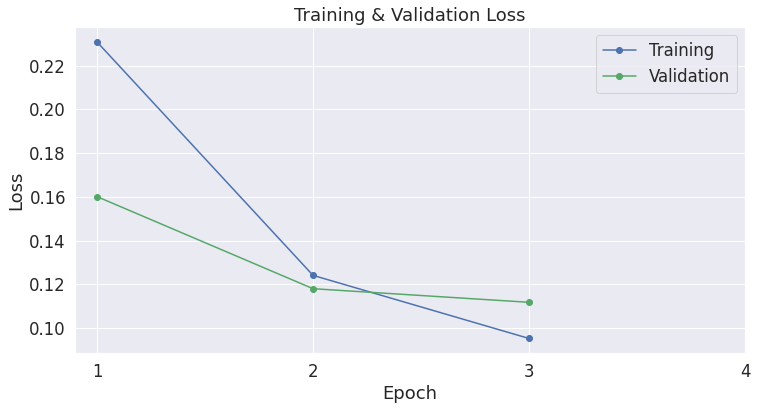

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### Accuracy per epoch - Training VS Validation

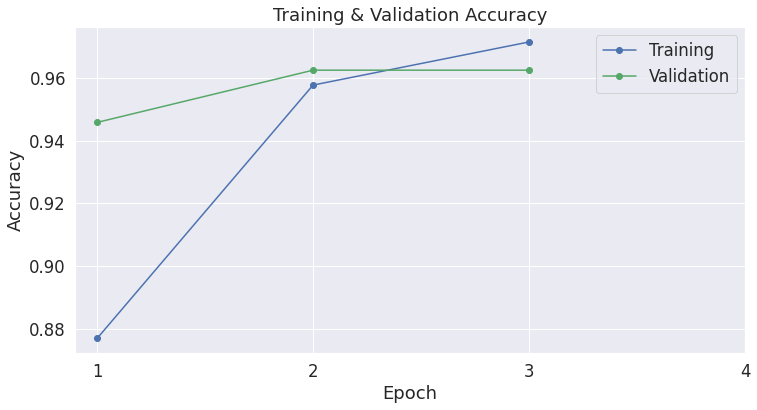

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training Accur.'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### F1 per epoch - Training VS Validation

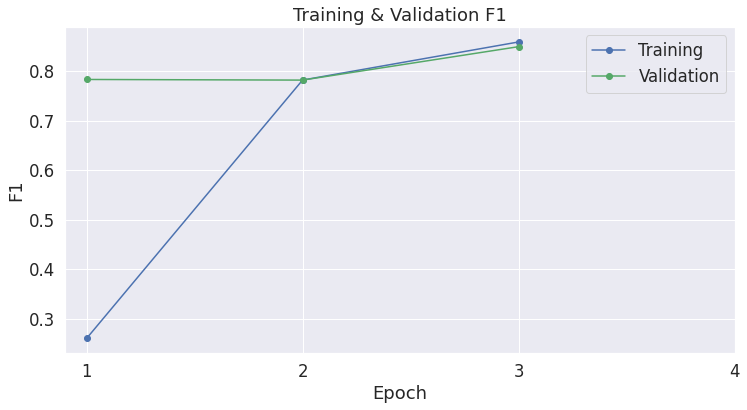

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training F1'], 'b-o', label="Training")
plt.plot(df_stats['Valid. F1'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##### Recall per epoch - Training VS Validation

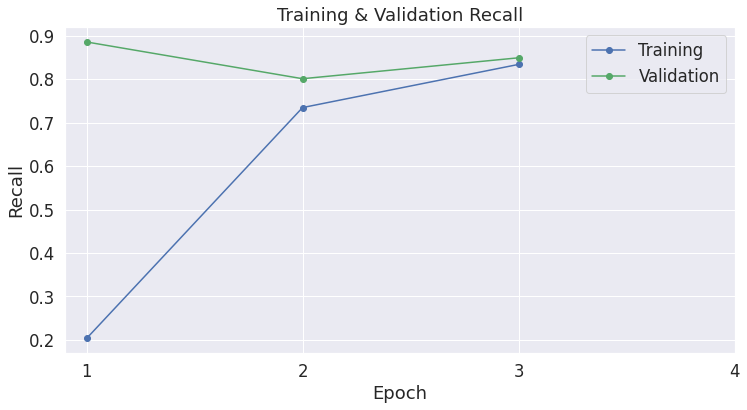

In [ ]:
# Plot the learning curve.
plt.plot(df_stats['Training Recall'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Recall'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#model_name = "Bert4SeqClassif_20220802015.pt"
#torch.save(model.state_dict(), model_name)

###model_name = "Bert4SeqClassif_20220804_1031_wPersistency.pt" # 90(95-05)-10
###model_name = "Bert4SeqClassif_20220804_1134_wPersistency.pt" # 96(95-05)-04

##Testing the model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = NUM_CLASSES, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

# Load the model and dictionary
model.load_state_dict(torch.load('Bert4SeqClassif_20220804_1134_wPersistency.pt'))#, map_location=torch.device('cpu') or cuda. Both work #Bert4SeqClassif_202207072015.pt #Bert4SeqClassif_augm_20220804_0231.pt

Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

<All keys matched successfully>

In [ ]:
# Reading sentences and labels from Testing set
all_sentences = get_sentences("ToS/TestSet/Sentences/")
all_labels = get_labels("ToS/TestSet/Labels/")

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
tmp_bool = True

# For every sentence...
for sent in all_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Pad & truncate all sentences.
                        pad_to_max_length = True, #is deprecated
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    if tmp_bool:
      tmp_bool = False
      print(f'Keys of encoded_dict: {encoded_dict.keys()}')
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(all_labels)

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attention_masks, labels)

test_dataloader = DataLoader(
            test_dataset,  # The test samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Keys of encoded_dict: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
# ========================================
#               Test
# ========================================
# After the completion of each test epoch, measure our performance on
# our test set.

print("Running Testing...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

test_preds = []
test_targets = []

# Tracking variables 
total_test_accuracy = 0
total_test_loss = 0
nb_test_steps = 0

io_total_test_acc = 0
io_total_test_prec = 0
io_total_test_recall = 0
io_total_test_f1 = 0

# Evaluate data for one epoch
for batch in test_dataloader:
    
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

    # Get the loss and "logits" output by the model. The "logits" are the 
    # output values prior to applying an activation function like the 
    # softmax.
    loss = result.loss
    logits = result.logits

    test_preds.extend(logits.argmax(dim=1).cpu().numpy())
    test_targets.extend(batch[2].numpy())

    # Accumulate the test loss.
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_test_accuracy += flat_accuracy(logits, label_ids)
    
    test_acc = accuracy_score(test_targets, test_preds)
    test_precision = precision_score(test_targets, test_preds)
    test_recall = recall_score(test_targets, test_preds)
    test_f1 = f1_score(test_targets, test_preds)

    io_total_test_acc += test_acc
    io_total_test_prec += test_precision
    io_total_test_recall += test_recall
    io_total_test_f1 += test_f1

    """
    print(
            f'Test_acc : {test_acc}\n\
            Test_F1 : {test_f1}\n\
            Test_precision : {test_precision}\n\
            Test_recall : {test_recall}\n\n\n'
          )
    """

# Report the final accuracy for this test run.
avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))
avg_test_acc = io_total_test_acc / len(test_dataloader)
avg_test_prec = io_total_test_prec / len(test_dataloader)
avg_test_recall = io_total_test_recall / len(test_dataloader)
avg_test_f1 = io_total_test_f1 / len(test_dataloader)
print("  =>Accuracy:  {0:.2f}".format(avg_test_acc))
print("  =>Precision: {0:.2f}".format(avg_test_prec))
print("  =>Recall:    {0:.2f}".format(avg_test_recall))
print("  =>F1:        {0:.2f}".format(avg_test_f1))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

# Measure how long the test run took.
test_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))


Running Testing...
  Accuracy: 0.97
  =>Accuracy:  0.93
  =>Precision: 0.73
  =>Recall:    0.75
  =>F1:        0.74
  Test Loss: 0.09
  Test took: 0:00:02
